目录：
* 简易版SVM
* 完整版SVM
* 带核函数的SVM
    * 用圆形数据验证
    * 用月亮形数据验证

# 简易版SVM

SMO函数的伪代码：
创建一个alpha向量并将其初始化伪0
当迭代次数小于最大迭代次数时（外循环）：
* 对数据集中的每个数据向量（内循环）：
    * 如果该数据向量可以被优化：
        * 随机选择另外一个数据向量
        * 同时优化这两个向量
        * 如果两个向量都不能被优化，退出内循环
    * 如果所有向量都没被优化，增加迭代次数，进行下一次循环

具体实现的伪代码
iter:没有任何$\alpha$变化的情况下遍历数据集的次数，只有在所有数据集上遍历maxiter后，且不再发生任何$\alpha$的修改后，才退出循环


while(iter<maxiter):  
&emsp; alphaPairChanged=0 #用来记录这次遍历中是否有alpha进行了更新  
&emsp; for i in range(m):  
&emsp;&emsp;if((Ei*yi<-toler) and alpha[i]<C) or Ei*yi>toler and alpha[i]>0):#不满足KKT条件的另一种表述  
&emsp;&emsp;&emsp;j随机选取  
&emsp;&emsp;&emsp;计算L和H  
&emsp;&emsp;&emsp;if(L==H)<font color=red>continue</font> #说明无法调整j  
&emsp;&emsp;&emsp;if(eta<=0)<font color=red>continue</font> #说明矩阵计算异常  
&emsp;&emsp;&emsp;更新j  
&emsp;&emsp;&emsp;if j的更新幅度太小<font color=red>continue</font>  
&emsp;&emsp;&emsp;更新i,b  
&emsp;&emsp;&emsp;alphaPairChanged+=1  


&emsp;if alphaPairChanged==0:iter+=1  
&emsp;else:iter=0  
return b,alpha  

In [198]:
class simple_SVM:
    def __init__(self,kernel='linear',max_iter=30):
        self.max_iter = max_iter
        self._kernel = kernel
    
    def _calE(self,i):
        return self._u(i)-self.y[i]
    
    def _u(self,i):
        return np.sum(self.X.dot(self.X[i])*self.alpha*self.y)+self.b
    
    def _KKT(self,i):
        yu = self._u(i)*self.y[i]
        if np.abs(self.alpha[i] - 0) <= self.epsilon:
            return yu >= 1+self.epsilon
        elif 0<self.alpha[i]<self.C:
            return np.abs(yu - 1) <= self.epsilon
        else:
            return yu <= 1-self.epsilon

    def kernel(self,i,j):
        if self._kernel == 'linear':
            return self.X[i].dot(self.X[j])
    
    def _new_alpha(self,i,j):
        if self.y[i]== self.y[j]:
            L = max(0,self.alpha[i]+self.alpha[j]-self.C)
            H = min(self.C,self.alpha[i]+self.alpha[j])
        else:
            L = max(0,self.alpha[j]-self.alpha[i])
            H = min(self.C,self.C+self.alpha[j]-self.alpha[i])
        
        if L==H:
            print("H=L")
            return 0,0,0 #flag=0
        
        eta = self.kernel(i,i)+self.kernel(j,j)-2*self.kernel(i,j)
        if eta <= 0:
            print("eta <= 0")
            return 0,0,0 #flag=0
        
        alpha_2_un = self.alpha[j]+self.y[j]*(self.E[i]-self.E[j])/eta
        
        if alpha_2_un > H:
            alpha_2_new = H
        elif alpha_2_un < L:
            alpha_2_new = L
        else:
            alpha_2_new = alpha_2_un
        
        if abs(alpha_2_new -self.alpha[j])<= self.epsilon:
            print("j not moving enough continue")
            return 0,0,0 #flag=0
        
        alpha_1_new=self.alpha[i]+self.y[i]*self.y[j]*(self.alpha[j]-alpha_2_new)
        
        return alpha_1_new,alpha_2_new,1 #flag=1,alpha1和alpha2正常更新
        
        
    
    def fit(self,features,labels,C=1,epsilon=1e-7):
        
        self.X = features
        self.y = labels
        self.b = 0
        self.C = C
        self.alpha = np.zeros(len(self.X))
        self.epsilon=epsilon
        self.E = np.array([self._calE(k) for k in range(len(self.X))])
        self.w = 0
        
        iter=0
        while(iter < self.max_iter):
            
            alphaPairChanged = 0
            for i in range(len(self.X)):
                
                if self._KKT(i):
                    continue
                
                #select j
                j=i
                while(j==i):
                    j=np.random.randint(0,len(self.X))
                
                
                alpha_1_new,alpha_2_new,flag=self._new_alpha(i,j)
                if flag==0:
                    continue
            
                b1_new = -self.E[i]-self.y[i]*self.kernel(i,i)*(alpha_1_new-self.alpha[i])-self.y[j]*self.kernel(j,i)*(alpha_2_new-self.alpha[j])+self.b
                b2_new = -self.E[j]-self.y[i]*self.kernel(i,j)*(alpha_1_new-self.alpha[i])-self.y[j]*self.kernel(j,j)*(alpha_2_new-self.alpha[j])+self.b
        
                if 0 < alpha_1_new <self.C:
                    b_new = b1_new
                elif 0 < alpha_2_new <self.C:
                    b_new = b2_new
                else:
                    b_new = (b1_new+b2_new)/2
        
                self.alpha[i]=alpha_1_new
                self.alpha[j]=alpha_2_new
                self.b = b_new
            
                alphaPairChanged += 1
                for k in range(len(self.X)):
                    self.E[k]=self._calE(k)
            
            if(alphaPairChanged==0): iter+=1
            else:iter=0
            print("iteration number :%d"%(iter))
 
        self.w = self._weight()
    def _weight(self):
        return np.sum(self.X*np.tile(self.y.reshape(-1,1),(1,self.X.shape[1]))*np.tile(self.alpha.reshape(-1,1),(1,self.X.shape[1])),axis=0)
       

In [6]:
import numpy as np
import matplotlib.pyplot as plt

X=np.array([
            [0,6],
            [1,5],
            [1,7],
            [3,3],
            [4,3],
            [3,1]])
y=np.array([1,1,1,-1,-1,-1])

plt.scatter(X[y==1,0],X[y==1,1],label='+',color='r')
plt.scatter(X[y==-1,0],X[y==-1,1],label='-',color='b')
plt.legend()

In [200]:
clf = simple_SVM()
clf.fit(X,y,C=100)

j not moving enough continue
iteration number :0
j not moving enough continue
iteration number :0
iteration number :0
j not moving enough continue
iteration number :1
j not moving enough continue
iteration number :2
j not moving enough continue
iteration number :3
j not moving enough continue
iteration number :0
j not moving enough continue
iteration number :1
j not moving enough continue
iteration number :2
j not moving enough continue
iteration number :3
iteration number :0
iteration number :0
iteration number :1
iteration number :2
iteration number :3
iteration number :4
iteration number :5
iteration number :6
iteration number :7
iteration number :8
iteration number :9
iteration number :10
iteration number :11
iteration number :12
iteration number :13
iteration number :14
iteration number :15
iteration number :16
iteration number :17
iteration number :18
iteration number :19
iteration number :20
iteration number :21
iteration number :22
iteration number :23
iteration number :24
iter

In [201]:
clf.alpha

array([0.  , 0.25, 0.  , 0.25, 0.  , 0.  ])

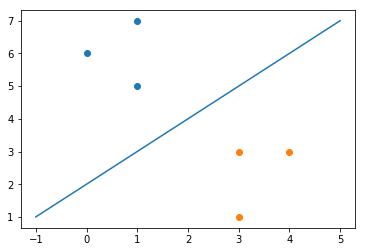

In [202]:
w = clf.w
b = clf.b
clf.alpha

x_plot=np.linspace(-1,5,10000)
y_plot=(-b-w[0]*x_plot)/w[1]

plt.scatter(X[y==1,0],X[y==1,1])
plt.scatter(X[y==-1,0],X[y==-1,1])
plt.plot(x_plot,y_plot)

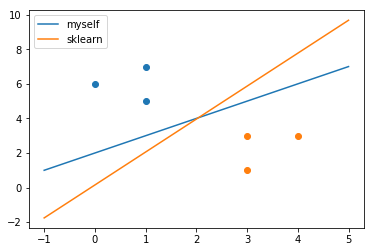

In [203]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X,y)
w0=clf.coef_
b0=clf.intercept_
x_plot=np.linspace(-1,5,1000)
y_plot=(-b-w[0]*x_plot)/w[1]
y_plot2=(-b0-w0[0,0]*x_plot)/w0[0,1]
plt.scatter(X[y==1,0],X[y==1,1])
plt.scatter(X[y==-1,0],X[y==-1,1])
plt.plot(x_plot,y_plot,label='myself')
plt.plot(x_plot,y_plot2,label='sklearn')
plt.legend()

In [204]:
from sklearn.datasets import load_iris
iris=load_iris()
X=iris.data[iris.target!=2]
X=X[:,0:2]
y=iris.target[iris.target!=2]
y[y==0]=-1

clf = simple_SVM(max_iter=20)
clf.fit(X,y,C=5000)
w = clf.w
b = clf.b

H=L
H=L
j not moving enough continue
H=L
H=L
H=L
j not moving enough continue
H=L
j not moving enough continue
j not moving enough continue
j not moving enough continue
j not moving enough continue
H=L
j not moving enough continue
H=L
H=L
H=L
H=L
H=L
H=L
j not moving enough continue
j not moving enough continue
iteration number :0
j not moving enough continue
j not moving enough continue
j not moving enough continue
j not moving enough continue
j not moving enough continue
j not moving enough continue
H=L
H=L
j not moving enough continue
j not moving enough continue
H=L
j not moving enough continue
H=L
j not moving enough continue
j not moving enough continue
j not moving enough continue
j not moving enough continue
j not moving enough continue
iteration number :0
j not moving enough continue
j not moving enough continue
j not moving enough continue
j not moving enough continue
j not moving enough continue
j not moving enough continue
j not moving enough continue
j not moving enough co

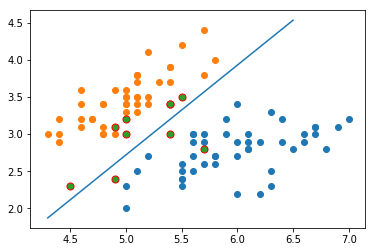

In [205]:
x_plot=np.linspace(4.3,6.5,10000)
y_plot=(-b-w[0]*x_plot)/w[1]
plt.scatter(X[y==1,0],X[y==1,1])
plt.scatter(X[y==-1,0],X[y==-1,1])
plt.scatter(X[clf.alpha!=0,0],X[clf.alpha!=0,1],edgecolors="red",s=50,linewidths=1)
plt.plot(x_plot,y_plot)

# 完整的Platt SMO算法

仔细读了一边书中的代码，写的甚是繁琐，大体的思想是和李航老师的《统计学习方法》中提到的思路一致，所以接下来，按照自己的理解来写。

伪代码  
while iter<maxiter 或者 alphaPairChanged!=0：
&emsp; alphaPairChanged=0
&emsp;index_list=np.argsort(alpha) #保证先遍历0~C之间的alpha  
&emsp;for i in index_list:   
&emsp;&emsp;alphaPairsChange += innerL(i)  
&emsp;&emsp;if alphaPairsChange>0:iter+=1;break;  

其中innerL(i)的设计和之前的算法类似，只是在选取j的时候，会按照最大步长来选择

In [206]:
class plat_SVM:
    def __init__(self,kernel='linear',max_iter=30):
        self.max_iter = max_iter
        self._kernel = kernel
    
    def _calE(self,i):
        return self._u(i)-self.y[i]
    
    def _u(self,i):
        return np.sum(self.X.dot(self.X[i])*self.alpha*self.y)+self.b
    
    def _KKT(self,i):
        yu = self._u(i)*self.y[i]
        if np.abs(self.alpha[i] - 0) <= self.epsilon:
            return yu >= 1+self.epsilon
        elif 0<self.alpha[i]<self.C:
            return np.abs(yu - 1) <= self.epsilon
        else:
            return yu <= 1-self.epsilon

    def kernel(self,i,j):
        if self._kernel == 'linear':
            return self.X[i].dot(self.X[j])
    
    def _new_alpha(self,i,j):
        if self.y[i]== self.y[j]:
            L = max(0,self.alpha[i]+self.alpha[j]-self.C)
            H = min(self.C,self.alpha[i]+self.alpha[j])
        else:
            L = max(0,self.alpha[j]-self.alpha[i])
            H = min(self.C,self.C+self.alpha[j]-self.alpha[i])
        
        if L==H:
            print("H=L")
            return 0,0,0 #flag=0
        
        eta = self.kernel(i,i)+self.kernel(j,j)-2*self.kernel(i,j)
        if eta <= 0:
            print("eta <= 0")
            return 0,0,0 #flag=0
        
        alpha_2_un = self.alpha[j]+self.y[j]*(self.E[i]-self.E[j])/eta
        
        if alpha_2_un > H:
            alpha_2_new = H
        elif alpha_2_un < L:
            alpha_2_new = L
        else:
            alpha_2_new = alpha_2_un
        
        if abs(alpha_2_new -self.alpha[j])<= self.epsilon:
            print("j not moving enough continue")
            return 0,0,0 #flag=0
        
        alpha_1_new=self.alpha[i]+self.y[i]*self.y[j]*(self.alpha[j]-alpha_2_new)
        
        return alpha_1_new,alpha_2_new,1 #flag=1,alpha1和alpha2正常更新
        
        
    
    def fit(self,features,labels,C=1,epsilon=1e-7):
        
        self.X = features
        self.y = labels
        self.b = 0
        self.C = C
        self.alpha = np.zeros(len(self.X))
        self.epsilon=epsilon
        self.E = np.array([self._calE(k) for k in range(len(self.X))])
        self.w = 0
        
        alphaPairChanged=1
        iter=0
        while (iter < self.max_iter) and (alphaPairChanged!=0):
            
            alphaPairChanged = 0
            index_list = np.argsort(self.alpha)[::-1]
            for i in index_list:
                if self._KKT(i):
                    continue
                
                #select j
                E_temp = np.abs(self.E - self.E[i])
                E_index = np.argsort(E_temp)[::-1]
                for j in E_index:
                    if j==i:continue
                    break
                
                alpha_1_new,alpha_2_new,alphaPairChanged=self._new_alpha(i,j)
                iter += 1
                print("iteration:%d i:%d j:%d alphaPairChanged%d"%(iter,i,j,alphaPairChanged))
                if alphaPairChanged==0:
                    continue
            
                b1_new = -self.E[i]-self.y[i]*self.kernel(i,i)*(alpha_1_new-self.alpha[i])-self.y[j]*self.kernel(j,i)*(alpha_2_new-self.alpha[j])+self.b
                b2_new = -self.E[j]-self.y[i]*self.kernel(i,j)*(alpha_1_new-self.alpha[i])-self.y[j]*self.kernel(j,j)*(alpha_2_new-self.alpha[j])+self.b
        
                if 0 < alpha_1_new <self.C:
                    b_new = b1_new
                elif 0 < alpha_2_new <self.C:
                    b_new = b2_new
                else:
                    b_new = (b1_new+b2_new)/2
        
                self.alpha[i]=alpha_1_new
                self.alpha[j]=alpha_2_new
                self.b = b_new
            
                for k in range(len(self.X)):
                    self.E[k]=self._calE(k)
 
        self.w = self._weight()
    def _weight(self):
        return np.sum(self.X*np.tile(self.y.reshape(-1,1),(1,self.X.shape[1]))*np.tile(self.alpha.reshape(-1,1),(1,self.X.shape[1])),axis=0)
    
    def _predict(self,data):
        return np.sign(self.w.dot(data)+self.b)
        
    def predict(self,p):
        res=np.empty(len(p))
        for i in range(len(p)):
            res[i] = self._predict(p[i])
        return res

In [207]:
clf_plat = plat_SVM(max_iter=200)
clf_plat.fit(X,y,C=10)

iteration:1 i:99 j:49 alphaPairChanged1
H=L
iteration:2 i:36 j:22 alphaPairChanged0
j not moving enough continue
iteration:3 i:27 j:76 alphaPairChanged0
j not moving enough continue
iteration:4 i:28 j:76 alphaPairChanged0
H=L
iteration:5 i:31 j:22 alphaPairChanged0
j not moving enough continue
iteration:6 i:34 j:76 alphaPairChanged0
j not moving enough continue
iteration:7 i:35 j:76 alphaPairChanged0
H=L
iteration:8 i:98 j:76 alphaPairChanged0
j not moving enough continue
iteration:9 i:39 j:76 alphaPairChanged0
j not moving enough continue
iteration:10 i:41 j:76 alphaPairChanged0
j not moving enough continue
iteration:11 i:45 j:76 alphaPairChanged0
j not moving enough continue
iteration:12 i:25 j:76 alphaPairChanged0
j not moving enough continue
iteration:13 i:23 j:76 alphaPairChanged0
j not moving enough continue
iteration:14 i:1 j:76 alphaPairChanged0
j not moving enough continue
iteration:15 i:9 j:76 alphaPairChanged0
j not moving enough continue
iteration:16 i:10 j:76 alphaPairChan

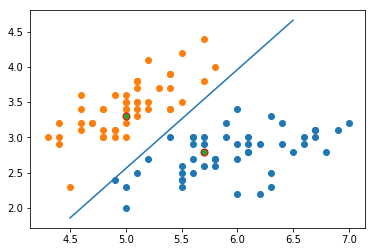

In [208]:
w = clf_plat.w
b = clf_plat.b
x_plot=np.linspace(4.5,6.5,10000)
y_plot=(-b-w[0]*x_plot)/w[1]
plt.scatter(X[y==1,0],X[y==1,1])
plt.scatter(X[y==-1,0],X[y==-1,1])
plt.scatter(X[clf_plat.alpha!=0,0],X[clf_plat.alpha!=0,1],edgecolors="red",s=50,linewidths=1)
plt.plot(x_plot,y_plot)

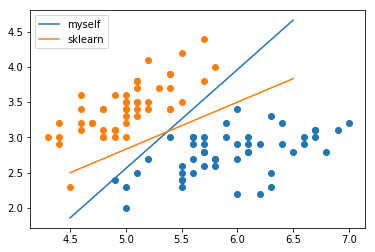

In [209]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X,y)
w0=clf.coef_
b0=clf.intercept_
x_plot=np.linspace(4.5,6.5,1000)
y_plot=(-b-w[0]*x_plot)/w[1]
y_plot2=(-b0-w0[0,0]*x_plot)/w0[0,1]
plt.scatter(X[y==1,0],X[y==1,1])
plt.scatter(X[y==-1,0],X[y==-1,1])
plt.plot(x_plot,y_plot,label='myself')
plt.plot(x_plot,y_plot2,label='sklearn')
plt.legend()

效果还是很不错的～
接下来是加上核函数
在原本的类中补充上predict方法，用于检测预测结果

In [217]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
X= load_iris().data
y= load_iris().target
X = X[y!=2,:]
y = y[y!=2]
y[y==0]=-1

In [221]:
%%time
X_train,X_test,y_train,y_test=train_test_split(X,y)
clf = LinearSVC()
clf.fit(X_train,y_train)

CPU times: user 1.78 ms, sys: 822 µs, total: 2.6 ms
Wall time: 1.59 ms


In [217]:
accuracy_score(clf.predict(X_test),y_test)

1.0

In [222]:
%%time
clf_myself=plat_SVM()
clf_myself.fit(X_train,y_train)

iteration:1 i:74 j:37 alphaPairChanged1
iteration:2 i:20 j:64 alphaPairChanged1
H=L
iteration:3 i:23 j:43 alphaPairChanged0
j not moving enough continue
iteration:4 i:37 j:43 alphaPairChanged0
j not moving enough continue
iteration:5 i:59 j:43 alphaPairChanged0
j not moving enough continue
iteration:6 i:72 j:43 alphaPairChanged0
H=L
iteration:7 i:57 j:43 alphaPairChanged0
H=L
iteration:8 i:38 j:43 alphaPairChanged0
H=L
iteration:9 i:40 j:43 alphaPairChanged0
j not moving enough continue
iteration:10 i:45 j:43 alphaPairChanged0
CPU times: user 9.42 ms, sys: 3.48 ms, total: 12.9 ms
Wall time: 10.8 ms


In [220]:
accuracy_score(clf_myself.predict(X_test),y_test)

1.0

# 更改SVM类使用核函数

在《机器学习实战》中的思想是，先利用核函数，将K(i,j)都求出来，之后直接使用

在fit函数中，所有需要进行核函数修改的地方有
* eta
* b1
* b2
* E

In [7]:
class kernel_plat_SVM:
    def __init__(self,kernel='linear',max_iter=30,gamma=1,c=0,degree=2):
        self.max_iter = max_iter
        self._kernel = kernel
        self.gamma=gamma
        self.degree=degree
        self.c=c
    
    def _calE(self,i):
        return self._u(i)-self.y[i]
    
    def _u(self,i):
        return np.sum(self.K[:,i]*self.alpha*self.y)+self.b
    
    def _KKT(self,i):
        yu = self._u(i)*self.y[i]
        if np.abs(self.alpha[i] - 0) <= self.epsilon:
            return yu >= 1+self.epsilon
        elif 0<self.alpha[i]<self.C:
            return np.abs(yu - 1) <= self.epsilon
        else:
            return yu <= 1-self.epsilon

    def _new_alpha(self,i,j):
        if self.y[i]== self.y[j]:
            L = max(0,self.alpha[i]+self.alpha[j]-self.C)
            H = min(self.C,self.alpha[i]+self.alpha[j])
        else:
            L = max(0,self.alpha[j]-self.alpha[i])
            H = min(self.C,self.C+self.alpha[j]-self.alpha[i])
        
        if L==H:
            print("H=L")
            return 0,0,0 #flag=0
        
        eta = self.K[i,i]+self.K[j,j]-2*self.K[i,j]
        if eta <= 0:
            print("eta <= 0")
            return 0,0,0 #flag=0
        
        alpha_2_un = self.alpha[j]+self.y[j]*(self.E[i]-self.E[j])/eta
        
        if alpha_2_un > H:
            alpha_2_new = H
        elif alpha_2_un < L:
            alpha_2_new = L
        else:
            alpha_2_new = alpha_2_un
        
        if abs(alpha_2_new -self.alpha[j])<= self.epsilon:
            print("j not moving enough continue")
            return 0,0,0 #flag=0
        
        alpha_1_new=self.alpha[i]+self.y[i]*self.y[j]*(self.alpha[j]-alpha_2_new)
        
        return alpha_1_new,alpha_2_new,1 #flag=1,alpha1和alpha2正常更新

        
    def calK(self):
        K = np.zeros((len(self.X),len(self.X)))
        for i in range(len(self.X)):
            if self._kernel=="linear":
                K[:,i]=self.X.dot(self.X[i])
            elif self._kernel=='poly':
                K[:,i]=(self.gamma*self.X.dot(self.X[i])+self.c)**self.degree
            elif self._kernel=='rbf':
                K[:,i]=np.exp(-self.gamma*np.sum((self.X-self.X[i])**2,axis=1))
        return K
    
    def fit(self,features,labels,C=1,epsilon=1e-7):
        
        self.X = features
        self.y = labels
        
        #计算kernel矩阵
        self.K = self.calK()
        
        
        self.b = 0
        self.C = C
        self.alpha = np.zeros(len(self.X))
        self.epsilon=epsilon
        self.E = np.array([self._calE(k) for k in range(len(self.X))])
        self.w = 0
        
        
        
        alphaPairChanged=1
        iter=0
        while (iter < self.max_iter) and (alphaPairChanged!=0):
            
            alphaPairChanged = 0
            index_list = np.argsort(self.alpha)[::-1]
            for i in index_list:
                if self._KKT(i):
                    continue
                
                #select j
                E_temp = np.abs(self.E - self.E[i])
                E_index = np.argsort(E_temp)[::-1]
                for j in E_index:
                    if j==i:continue
                    break
                
                alpha_1_new,alpha_2_new,alphaPairChanged=self._new_alpha(i,j)
                iter += 1
                print("iteration:%d i:%d j:%d alphaPairChanged%d"%(iter,i,j,alphaPairChanged))
                if alphaPairChanged==0:
                    continue
            
                b1_new = -self.E[i]-self.y[i]*self.K[i,i]*(alpha_1_new-self.alpha[i])-self.y[j]*self.K[j,i]*(alpha_2_new-self.alpha[j])+self.b
                b2_new = -self.E[j]-self.y[i]*self.K[i,j]*(alpha_1_new-self.alpha[i])-self.y[j]*self.K[j,j]*(alpha_2_new-self.alpha[j])+self.b
        
                if 0 < alpha_1_new <self.C:
                    b_new = b1_new
                elif 0 < alpha_2_new <self.C:
                    b_new = b2_new
                else:
                    b_new = (b1_new+b2_new)/2
        
                self.alpha[i]=alpha_1_new
                self.alpha[j]=alpha_2_new
                self.b = b_new
            
                for k in range(len(self.X)):
                    self.E[k]=self._calE(k)
        
        if self._kernel=='poly':
            self.w = self._weight()
    
    def _weight(self):
        return np.sum(self.X*np.tile(self.y.reshape(-1,1),(1,self.X.shape[1]))*np.tile(self.alpha.reshape(-1,1),(1,self.X.shape[1])),axis=0)
    
    def _predict(self,data):

        if self._kernel=="linear":
            kerneleval=self.vecX.dot(data)
        elif self._kernel=='poly':
            kerneleval=(self.gamma*self.vecX.dot(data)+self.c)**self.degree
        elif self._kernel=='rbf':
            kerneleval=np.exp(-self.gamma*np.sum((self.vecX-data)**2,axis=1))

        return np.sign(np.sum(kerneleval*self.vecAlpha*self.vecY)+self.b)
        
        
    def predict(self,p):
        
        non_index=np.nonzero(self.alpha)
        self.vecAlpha = self.alpha[non_index]
        self.vecY = self.y[non_index]
        self.vecX = self.X[non_index]
           
        res=np.empty(len(p))
        for i in range(len(p)):
            res[i] = self._predict(p[i])
        return res

## 用圆形数据检验下自己的SVM模型

In [8]:
from sklearn.datasets import make_circles
X,y=make_circles(factor=0.5,noise=0.15,random_state=66)
y[y==0]=-1

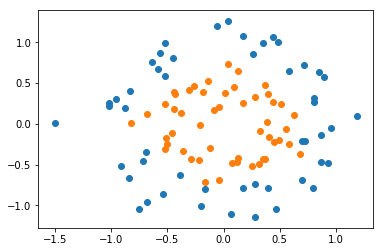

In [9]:
plt.scatter(X[y==-1,0],X[y==-1,1])
plt.scatter(X[y==1,0],X[y==1,1])

In [10]:
ker_clf = kernel_plat_SVM(kernel='poly')
ker_clf.fit(X,y)

iteration:1 i:99 j:32 alphaPairChanged1
iteration:2 i:36 j:79 alphaPairChanged1
iteration:3 i:26 j:70 alphaPairChanged1
iteration:4 i:27 j:58 alphaPairChanged1
H=L
iteration:5 i:28 j:83 alphaPairChanged0
H=L
iteration:6 i:29 j:83 alphaPairChanged0
H=L
iteration:7 i:31 j:83 alphaPairChanged0
H=L
iteration:8 i:32 j:49 alphaPairChanged0
H=L
iteration:9 i:33 j:83 alphaPairChanged0
iteration:10 i:35 j:49 alphaPairChanged1
H=L
iteration:11 i:37 j:49 alphaPairChanged0
H=L
iteration:12 i:98 j:49 alphaPairChanged0
H=L
iteration:13 i:38 j:49 alphaPairChanged0
H=L
iteration:14 i:39 j:49 alphaPairChanged0
H=L
iteration:15 i:41 j:49 alphaPairChanged0
H=L
iteration:16 i:44 j:49 alphaPairChanged0
iteration:17 i:25 j:21 alphaPairChanged1
H=L
iteration:18 i:24 j:12 alphaPairChanged0
j not moving enough continue
iteration:19 i:23 j:12 alphaPairChanged0
iteration:20 i:22 j:60 alphaPairChanged1
H=L
iteration:21 i:1 j:49 alphaPairChanged0
H=L
iteration:22 i:4 j:49 alphaPairChanged0
H=L
iteration:23 i:5 j:1

In [11]:
def plot_decision_boundary(model,axis):
    x0,x1 = np.meshgrid(
        np.linspace(axis[0],axis[1],int((axis[1]-axis[0])*100)).reshape(-1,1),
        np.linspace(axis[2],axis[3],int((axis[3]-axis[2])*100)).reshape(-1,1)
    )
    X_new = np.c_[x0.ravel(),x1.ravel()]
    
    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)
    
    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    
    plt.contourf(x0,x1,zz,cmap=custom_cmap)

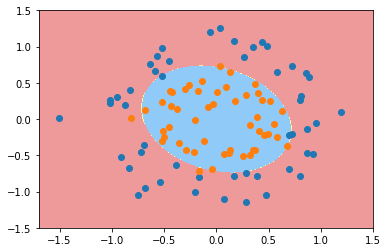

In [16]:
plot_decision_boundary(ker_clf,axis = [-1.7,1.5,-1.5,1.5])
plt.scatter(X[y==-1,0],X[y==-1,1])
plt.scatter(X[y==1,0],X[y==1,1])
plt.show()

In [18]:
from sklearn.datasets import make_moons
X,y=make_moons(noise=0.15,random_state=66)
y[y==0]=-1

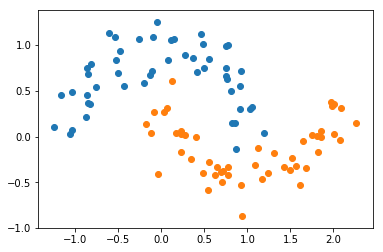

In [19]:
plt.scatter(X[y==-1,0],X[y==-1,1])
plt.scatter(X[y==1,0],X[y==1,1])

In [54]:
ker_clf = kernel_plat_SVM(kernel='rbf',gamma=2.8)
ker_clf.fit(X,y,C=10)

iteration:1 i:99 j:32 alphaPairChanged1
iteration:2 i:36 j:6 alphaPairChanged1
iteration:3 i:27 j:58 alphaPairChanged1
iteration:4 i:28 j:15 alphaPairChanged1
iteration:5 i:30 j:45 alphaPairChanged1
iteration:6 i:31 j:96 alphaPairChanged1
iteration:7 i:32 j:6 alphaPairChanged1
j not moving enough continue
iteration:8 i:34 j:96 alphaPairChanged0
j not moving enough continue
iteration:9 i:35 j:96 alphaPairChanged0
j not moving enough continue
iteration:10 i:37 j:96 alphaPairChanged0
j not moving enough continue
iteration:11 i:98 j:96 alphaPairChanged0
j not moving enough continue
iteration:12 i:38 j:96 alphaPairChanged0
j not moving enough continue
iteration:13 i:39 j:96 alphaPairChanged0
j not moving enough continue
iteration:14 i:41 j:96 alphaPairChanged0
j not moving enough continue
iteration:15 i:44 j:96 alphaPairChanged0
iteration:16 i:45 j:96 alphaPairChanged1
H=L
iteration:17 i:46 j:79 alphaPairChanged0
H=L
iteration:18 i:47 j:79 alphaPairChanged0
j not moving enough continue
iter

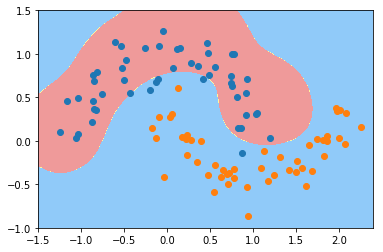

In [55]:
plot_decision_boundary(ker_clf,axis = [-1.5,2.4,-1,1.5])
plt.scatter(X[y==-1,0],X[y==-1,1])
plt.scatter(X[y==1,0],X[y==1,1])
plt.show()

# 对比sklearn的结果

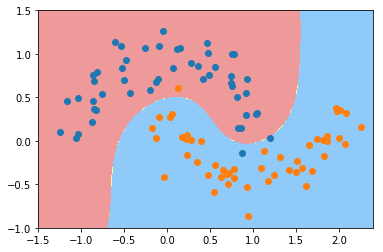

In [62]:
from sklearn.svm import SVC
ker_sklearn=SVC(gamma=2)
ker_sklearn.fit(X,y)
plot_decision_boundary(ker_sklearn,axis = [-1.5,2.4,-1,1.5])
plt.scatter(X[y==-1,0],X[y==-1,1])
plt.scatter(X[y==1,0],X[y==1,1])
plt.show()